#### Import necessary libraries

In [73]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from bs4 import BeautifulSoup
import re,string,unicodedata
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

from string import punctuation
from nltk import pos_tag, trigrams, bigrams
from nltk import FreqDist
from nltk.corpus import wordnet
from collections import Counter
from imblearn.over_sampling import SMOTE

import pickle

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LogisticRegression,SGDClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.svm import SVC

import re

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('jigsaw-toxic-comment-classification-challenge/train.csv')

In [3]:
df.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


At this point I'd like to concentrate on the prediction of the tweet being toxic or not. Thats why I'll drop all columns beside for "comment_text" (feature) and "toxic" (target)

In [4]:
df.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

In [5]:
df.drop(['id', 'severe_toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'], axis=1, inplace=True)

In [6]:
df.head()

,comment_text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   comment_text  159571 non-null  object
 1   toxic         159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [8]:
df['toxic'].value_counts(normalize=True)

0    0.904156
1    0.095844
Name: toxic, dtype: float64

Notice that the dataset is unbalanced

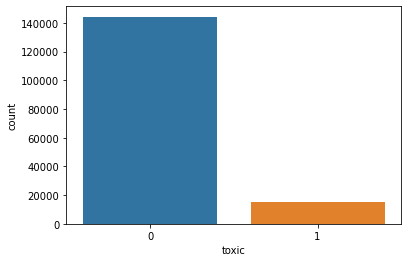

In [9]:
sns.countplot(x ='toxic', data=df);

Let's see what number of words each tweet consists

In [10]:
df['words_in_tweet'] = df['comment_text'].str.split().str.len()

#alternative way to write
#df['words_in_tweet'] = df['comment_text'].apply(lambda x: len(str(x).split()))

In [11]:
df.head()

,comment_text,toxic,words_in_tweet
0,Explanation\nWhy the edits made under my usern...,0,43
1,D'aww! He matches this background colour I'm s...,0,17
2,"Hey man, I'm really not trying to edit war. It...",0,42
3,"""\nMore\nI can't make any real suggestions on ...",0,113
4,"You, sir, are my hero. Any chance you remember...",0,13


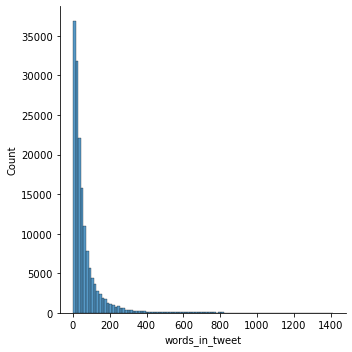

In [12]:
sns.displot(df['words_in_tweet'], bins = 100);

We can notice that our distribution is highly skewed to the right. There are small number of very long tweets the pull the dist

In [13]:
df['words_in_tweet'].describe()

count    159571.000000
mean         67.273527
std          99.230702
min           1.000000
25%          17.000000
50%          36.000000
75%          75.000000
max        1411.000000
Name: words_in_tweet, dtype: float64

There are a number of tweets that have a length of 1. Let's see what they are 

In [14]:
df[df['words_in_tweet']==1]

,comment_text,toxic,words_in_tweet
19815,(www.ebenefits.va.gov),0,1
52442,"14:53,",0,1
52475,User_talk:Blackson#Religious_bias,0,1
53787,92.24.199.233|92.24.199.233]],0,1
55751,Complaints/Mistakes,0,1
64904,http://en.wikipedia.org/wiki/Wikipedia_talk:No...,0,1
76037,http://finance.yahoo.com/news/7-fascinating-nu...,0,1
93586,{{unblock|yo,0,1
105657,Talk:E%3DMC%C2%B2_(Mariah_Carey_album)#Concern...,0,1
106891,http://en.wikipedia.org/wiki/Wikipedia:ELYES,0,1


In [15]:
length = len(df[df['words_in_tweet']==1])
print(f'there are {length} which have length of 1')

there are 17 which have length of 1


These tweets mainly consist links or undivisible expressions

In [16]:
mean_toxic = df[df['toxic'] ==1]['words_in_tweet'].mean()
mean_non_tox = df[df['toxic'] == 0]['words_in_tweet'].mean()

print(f'Mean number of words in:\n toxic comment {round(mean_toxic, 2)}\n non-toxic comment {round(mean_non_tox, 2)}')

Mean number of words in:
 toxic comment 51.29
 non-toxic comment 68.97


This is what i expected. 

Lets look which group of words (groups of 2 and groups of 3) appear most commonly in both classes (toxic/non_toxic)

In [17]:
toxic = df[df['toxic']==1]['comment_text']
non_toxic = df[df['toxic']==0]['comment_text']

In [18]:
def remove_punct(s):
    punct = set(string.punctuation)
    return ''.join([x for x in s if x not in punct])

stop = stopwords.words('english')

In [19]:
toxic_temp = toxic.str.lower().apply(remove_punct).str.split().values
toxic_temp = [item for sublist in toxic_temp for item in sublist]

toxic_words = [w for w in toxic_temp if w not in stop]


non_toxic_temp = non_toxic.str.lower().apply(remove_punct).str.split().values
non_toxic_temp = [item for sublist in non_toxic_temp for item in sublist]

non_toxic_words = [w for w in non_toxic_temp if w not in stop]

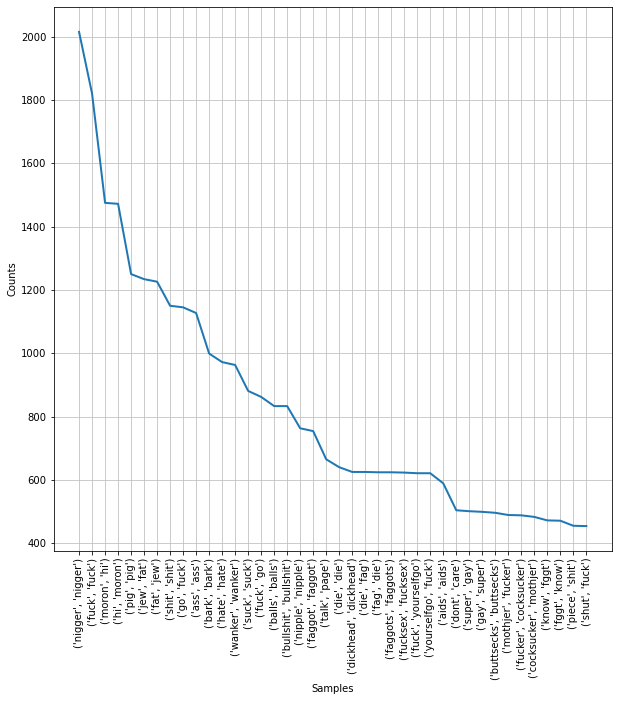

In [20]:
bigrams = list(ngrams(toxic_words, 2))
fdistBigram = FreqDist(bigrams)

plt.figure(figsize=(10,10))
fdistBigram.plot(40);

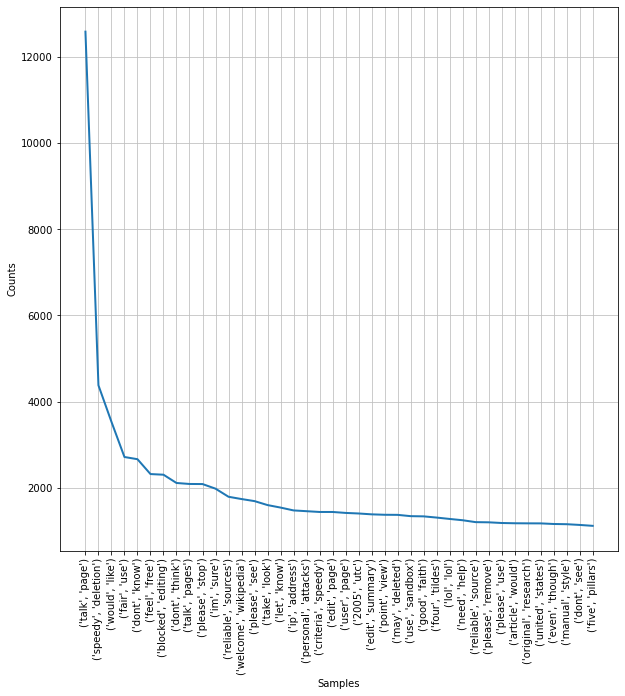

In [21]:
bigrams = list(ngrams(non_toxic_words, 2))
fdistBigram = FreqDist(bigrams)

plt.figure(figsize=(10,10))
fdistBigram.plot(40);

Let's visualize the most common words in both classes

In [22]:
wc = WordCloud(background_color="white", max_words=200)
wc.generate(str(' '.join(toxic)))

nwc = WordCloud(background_color="white", max_words=200)
nwc.generate(str(' '.join(non_toxic)))

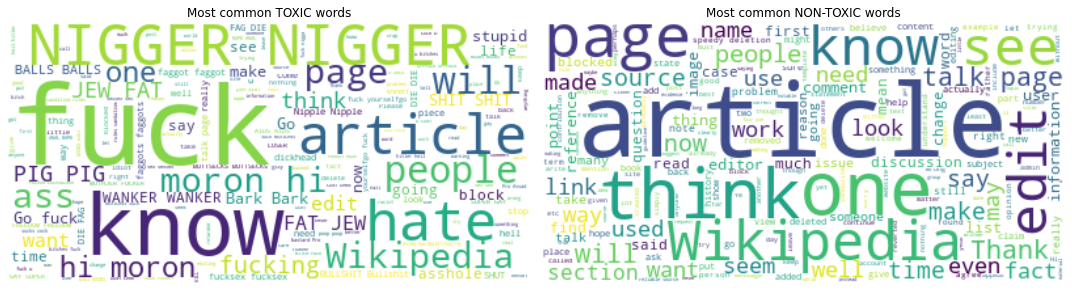

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,15))
axes[0].imshow(wc, interpolation='bilinear')
axes[1].imshow(nwc, interpolation='bilinear')

axes[0].title.set_text('Most common TOXIC words')
axes[1].title.set_text('Most common NON-TOXIC words')

[axi.set_axis_off() for axi in axes.ravel()]
fig.tight_layout()

time to model!

In [24]:
df.head()

,comment_text,toxic,words_in_tweet
0,Explanation\nWhy the edits made under my usern...,0,43
1,D'aww! He matches this background colour I'm s...,0,17
2,"Hey man, I'm really not trying to edit war. It...",0,42
3,"""\nMore\nI can't make any real suggestions on ...",0,113
4,"You, sir, are my hero. Any chance you remember...",0,13


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   comment_text    159571 non-null  object
 1   toxic           159571 non-null  int64 
 2   words_in_tweet  159571 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.7+ MB


In [27]:
y = df['toxic']
features = [col for col in df.columns if col!= "toxic"]
X = df[features]
skf = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
train_index, test_index = list(skf.split(X, y))[0]
df_test, df_train = df.iloc[test_index], df.iloc[train_index]

In [30]:
df_train.head()

,comment_text,toxic,words_in_tweet
1,D'aww! He matches this background colour I'm s...,0,17
2,"Hey man, I'm really not trying to edit war. It...",0,42
3,"""\nMore\nI can't make any real suggestions on ...",0,113
4,"You, sir, are my hero. Any chance you remember...",0,13
5,"""\n\nCongratulations from me as well, use the ...",0,13


In [32]:
def clean_text(text):
    text = text.lower()
    text = re.sub('@[A-Za-z0–9]+', ' ', text)
    text = re.sub('#', ' ', text)
    text = re.sub('https?:\/\/\S+', ' ', text)
    return text

In [40]:
df_train["comment_text"] = df_train["comment_text"].apply(lambda x: clean_text(x))
df_test["comment_text"] = df_test["comment_text"].apply(lambda x: clean_text(x))

In [42]:
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop and i.strip().lower().isalpha():
            final_text.append(i.strip().lower())
    return " ".join(final_text)

df_train["comment_text"] = df_train["comment_text"].apply(lambda x: remove_stopwords(x))
df_test["comment_text"] = df_test["comment_text"].apply(lambda x: remove_stopwords(x))

In [44]:
X = df_train['comment_text']
y = df_train['toxic']

In [50]:
X_test_final = df_test['comment_text']
y_test_final = df_test['toxic']

In [74]:
cv = TfidfTransformer()
X = cv.fit_transform(X)

In [75]:
X_test_final = cv.transform(X_test_final)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

In [59]:
smote = SMOTE(random_state = 402)
X_train, y_train = smote.fit_resample(X_train,y_train)

In [67]:
lr = LogisticRegression()
lr.fit(X_train,y_train)

y_pred_lr = lr.predict(X_test)
print(confusion_matrix(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))

[[19814  3261]
 [  611  1846]]
              precision    recall  f1-score   support

           0       0.97      0.86      0.91     23075
           1       0.36      0.75      0.49      2457

    accuracy                           0.85     25532
   macro avg       0.67      0.81      0.70     25532
weighted avg       0.91      0.85      0.87     25532



In [68]:
y_pred_lr = lr.predict(X_test_final)

In [69]:
print(confusion_matrix(y_test_final, y_pred_lr))
print(classification_report(y_test_final, y_pred_lr))

[[24811  4045]
 [  815  2244]]
              precision    recall  f1-score   support

           0       0.97      0.86      0.91     28856
           1       0.36      0.73      0.48      3059

    accuracy                           0.85     31915
   macro avg       0.66      0.80      0.70     31915
weighted avg       0.91      0.85      0.87     31915



In [70]:
# open a file, where you want to store the data
file = open('toxic_comments.pkl', 'wb')

# dump information to that file
pickle.dump(lr, file)